### Project reports
  - Broken down by _Tasks_ (see below), any notes you wish to make in how you or your group structured and carried out the tasks, and most importantly your __results__ in the form of completely labelled graphs, and __accompanying conclusions__ you draw from your results. 
  - Interim report about 4-6 pages(excluding appendices such as attached code, but _including_ figures).
  - __All code__ that you used during to project must be attached as an appendix to your reports.

In [1]:
# std vs Ntrials

# Ramp model ll maps
from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

import time

start_time = time.time()

## Setup ##

M = 20
actual_b = 1.2
actual_logs = np.log(0.5)
actual_x0 = 0.2

values_logs = np.linspace(np.log(0.04), np.log(4), M) # -3.22 - 1.386
values_b = np.linspace(0, 4, M)
values_x0 = np.linspace(0, 1, M)
K = 20
st = np.arange(K) # states
xt = st/(K-1)


T=100
time_points = np.linspace(1,T,T) # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3

Rh = 50
xs = 0.2
bin_size = 20
bin_size_2 = 50
bin_edges = np.arange(0, 1e3+bin_size, bin_size)

# plt.figure(figsize=(5, 3))
values_N = [1,4,16,64]
ave_results = np.zeros((len(values_N),6)) # for 4 different N, expected para and std: [m,r,x0]
for N_idx in range(len(values_N)):
    N =  values_N[N_idx]
    for repeat in range(int(64/N*5)):        
        
        ramp = RampModel(beta=actual_b, sigma=np.exp(actual_logs), x0=actual_x0, Rh=50)
        [spikes, _, _, _, _] = ramp.simulate_HMM(Ntrials=N, T=T, K=K, get_rate=True)

        counts_matrix= generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=False, return_counts=True);

        log_prior = np.log(1/M**3)
        model_ll = np.zeros((M,M,M))

        log_prior = np.log(1/M**3)
        model_ll = np.zeros((M,M,M))

        for b_idx in range(M):
            for s_idx in range(M):
                for x_idx in range(M):

                    b = values_b[b_idx]
                    logs = values_logs[s_idx]
                    x0 = values_x0[x_idx]

                    ramp = RampModel(beta=b, sigma=np.exp(logs), x0=x0, Rh=50)
                    [_, _, _, normalized_log_trans_matrix, normalized_log_pi0] = ramp.simulate_HMM(Ntrials=0, 
                                                                                                   T=T, 
                                                                                                   K=K, 
                                                                                                   get_rate=True)
                    normalized_log_trans_matrix = normalized_log_trans_matrix[np.newaxis, :, :] # (1,K,K) for homogeneous MC

                    lls = poisson_logpdf(counts=counts_matrix, lambdas= xt*Rh*dt, mask=None) # N x T x K 

                    # Model log-likelihood for N trials:
                    for n in range(N):
                        model_ll[b_idx, s_idx, x_idx] += hmm_normalizer(log_pi0 = normalized_log_pi0, 
                                                                        log_Ps = normalized_log_trans_matrix, 
                                                                        ll = lls[n])


        unnormalised_log_poste = model_ll + log_prior
        log_poste = unnormalised_log_poste - logsumexp_scipy(unnormalised_log_poste)
        
        poste = np.exp(log_poste) + 1e-16
        poste_b = np.sum(poste,axis=(1,2)) # b is axis0, so sum over axis 1,2
        poste_logs = np.sum(poste,axis=(0,2))
        poste_x0 = np.sum(poste,axis=(0,1))
        
        expected_b = np.sum(values_b * poste_b)
        var_b = np.sum(poste_b * (values_b - expected_b)**2)
        std_b = np.sqrt(var_b)

        expected_logs = np.sum(values_logs * poste_logs)
        var_logs = np.sum(poste_logs * (values_logs - expected_logs)**2)
        std_logs = np.sqrt(var_logs)

        expected_x0 = np.sum(values_x0 * poste_x0)
        var_x0 = np.sum(poste_x0 * (values_x0 - expected_x0)**2)
        std_x0 = np.sqrt(var_x0)
        
        ave_results[N_idx] += np.array([expected_b, std_b, expected_logs, std_logs, expected_x0, std_x0])
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Takes：", elapsed_time, "s")   
    ave_results[N_idx] /= int(64/N)
    
#     values_N = [1,4,16,64]
# ave_results = np.zeros((len(values_N),6)) # for 4 different N, expected para and std: [m,r,x0]
# print(ave_results)




Takes： 3.8328020572662354 s
Takes： 7.611408948898315 s
Takes： 11.268425941467285 s
Takes： 14.793589115142822 s
Takes： 18.314038038253784 s
Takes： 21.988213062286377 s
Takes： 25.6093430519104 s
Takes： 29.266030073165894 s
Takes： 32.89225387573242 s
Takes： 36.43073892593384 s
Takes： 39.99052309989929 s
Takes： 43.6608669757843 s
Takes： 47.236838817596436 s
Takes： 51.01250410079956 s
Takes： 54.66812801361084 s
Takes： 58.21887993812561 s
Takes： 61.97490096092224 s
Takes： 65.60587811470032 s
Takes： 69.26306200027466 s
Takes： 72.87353491783142 s
Takes： 76.43977093696594 s
Takes： 80.33537101745605 s
Takes： 84.25038409233093 s
Takes： 88.0050060749054 s
Takes： 91.73746418952942 s
Takes： 95.70860695838928 s
Takes： 99.5386791229248 s
Takes： 103.33067297935486 s
Takes： 106.85018181800842 s
Takes： 110.40328812599182 s
Takes： 113.93981218338013 s
Takes： 117.4669840335846 s
Takes： 121.00797891616821 s
Takes： 124.53633522987366 s
Takes： 128.0763750076294 s
Takes： 131.64282298088074 s
Takes： 135.2301430

Takes： 1104.8714680671692 s
Takes： 1108.3887209892273 s
Takes： 1111.9129221439362 s
Takes： 1115.4469430446625 s
Takes： 1118.9794518947601 s
Takes： 1122.4900591373444 s
Takes： 1126.4670870304108 s
Takes： 1130.0700850486755 s
Takes： 1133.7230641841888 s
Takes： 1137.4160430431366 s
Takes： 1141.0905499458313 s
Takes： 1144.7707600593567 s
Takes： 1148.4813539981842 s
Takes： 1152.1753060817719 s
Takes： 1155.890877008438 s
Takes： 1159.5919959545135 s
Takes： 1163.2919130325317 s
Takes： 1166.9894289970398 s
Takes： 1175.1575548648834 s
Takes： 1183.2970821857452 s
Takes： 1191.42524600029 s
Takes： 1199.6080901622772 s
Takes： 1208.0262660980225 s
Takes： 1216.2272791862488 s
Takes： 1224.2773299217224 s
Takes： 1232.209629058838 s
Takes： 1240.144364118576 s
Takes： 1248.2204940319061 s
Takes： 1256.1524920463562 s
Takes： 1263.9706931114197 s
Takes： 1271.7612080574036 s
Takes： 1279.598121881485 s
Takes： 1287.483397245407 s
Takes： 1295.2820370197296 s
Takes： 1303.4631130695343 s
Takes： 1311.510899066925 s


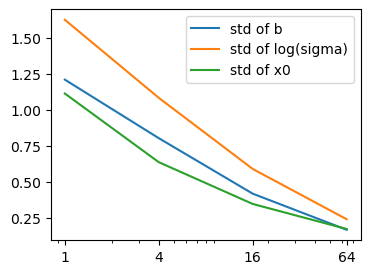

In [3]:

plt.figure(figsize=(4, 3))
# actual_b = 1.2
# actual_logs = np.log(0.5)
# actual_x0 = 0.2
plt.plot(values_N, ave_results[:,1]/values_b[-1], label="std of b")
plt.plot(values_N, ave_results[:,3]/values_logs[-1], label="std of log(sigma)")
plt.plot(values_N, ave_results[:,5]/values_x0[-1], label="std of x0")

plt.xscale('log')

plt.legend()
plt.xticks(values_N,values_N)
plt.show()


[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.  ]


KeyboardInterrupt: 

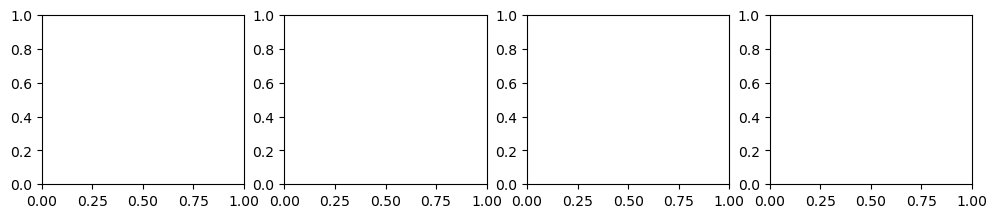

In [2]:
# Ramp model xt error heatmaps

from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

import time

start_time = time.time()

M = 41

values_logs = np.linspace(np.log(0.004), np.log(40), M)
values_beta = np.linspace(0, 10, M)

values_x0 = np.linspace(0, 1, M)
values_logRh = np.linspace(np.log(50*1e-2), np.log(50*1e2), M)


T=100
time_points = np.arange(T)  # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3

xr = 0.2
Rh = 50
bin_size = 20
bin_size_2 = 50
bin_edges = np.arange(0, 1e3+bin_size, bin_size)

# plt.figure(figsize=(5, 3))
K = 51
st = np.arange(K) # states
xt = st/(K-1)
N = 50

Rh_values = [0, 50, 50000]
fig, axs = plt.subplots(1, len(Rh_values)+1, figsize=(3 * len(Rh_values) + 3, 2.2))



values_beta = np.linspace(0,10, M)
print(values_beta)



for idx, Rh in enumerate(Rh_values):

    RMSE_xt = np.empty((M,M))
    for b_idx in range(M):
        for s_idx in range(M):
            b = values_beta[b_idx]
            s = np.exp(values_logs[s_idx])

            ramp = RampModel(beta=b, sigma=s, x0=xr, Rh=Rh)
            [spikes, actual_xt, _, normalized_log_trans_matrix, normalized_log_pi0] = ramp.simulate_HMM(Ntrials=N, T=T, K=K, get_rate=True)
            normalized_log_trans_matrix = normalized_log_trans_matrix[np.newaxis, :, :] # (1,K,K) for homogeneous MC

            # counts_matrix is n(1:T) for N trials. shape=(N,T)
            counts_matrix= generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=False, return_counts=True);

            # ll: nt ~ Poission(st/(k-1) * Rh * dt)
            # lls: ll for N trials. lls[0] to get ll of first trial
            lls = poisson_logpdf(counts=counts_matrix,lambdas=xt*Rh*dt, mask=None) # N x T x K 
            
            expected_states = np.empty((N,T,K))
            normalizer = np.empty(N,)
            for n in range(N):
                expected_states[n], normalizer[n] = hmm_expected_states(log_pi0=normalized_log_pi0, 
                                                                        log_Ps=normalized_log_trans_matrix, 
                                                                        ll=lls[n],
                                                                        filter=True)
            # expected_states: N x T x K
            # expected_xt: N x T; actual_xt: N x T
            # errors: N x T, squared errors
            expected_xt = np.sum(expected_states * xt,axis=2) # sum over K states
            squared_errors = (expected_xt-actual_xt)**2 
            RMS_error_t = np.average(squared_errors, axis=0)**0.5 # average over N trials
            RMSE_xt[b_idx, s_idx] = np.average(RMS_error_t) + 1e-16
            
    axs[idx].set_title(f"Rh={Rh}")
    X, Y = np.meshgrid(np.exp(values_logs), values_beta)
    im = axs[idx].pcolormesh(X, Y, RMSE_xt, cmap='viridis', norm=colors.LogNorm(vmin=1e-3, vmax=0.3))
    axs[idx].set_xscale('log')
    axs[idx].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    axs[idx].set_xlabel('sigma')
    axs[idx].set_ylabel('beta', labelpad=-5)
    axs[idx].set_aspect('auto')

# (X0, Rh)
RMSE_xt = np.empty((M,M))

beta=1.2
sigma=0.6
for r_idx in range(M):
    for x_idx in range(M):
        xr = values_x0[x_idx]
        Rh = np.exp(values_logRh[r_idx])

        ramp = RampModel(beta=beta, sigma=sigma, x0=xr, Rh=Rh)
        [spikes, actual_xt, _, normalized_log_trans_matrix, normalized_log_pi0] = ramp.simulate_HMM(Ntrials=N, T=T, K=K, get_rate=True)
        normalized_log_trans_matrix = normalized_log_trans_matrix[np.newaxis, :, :] # (1,K,K) for homogeneous MC
        
        # counts_matrix is n(1:T) for N trials. shape=(N,T)
        counts_matrix= generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=False, return_counts=True);

        # ll: nt ~ Poission(st/(k-1) * Rh * dt)
        # lls: ll for N trials. lls[0] to get ll of first trial
        lls = poisson_logpdf(counts=counts_matrix,lambdas=xt*Rh*dt, mask=None) # N x T x K 

        expected_states = np.empty((N,T,K))
        normalizer = np.empty(N,)
        for n in range(N):
            expected_states[n], normalizer[n] = hmm_expected_states(log_pi0=normalized_log_pi0, 
                                                                    log_Ps=normalized_log_trans_matrix, 
                                                                    ll=lls[n],
                                                                    filter=True)

        # expected_states: N x T x K
        # expected_xt: N x T; actual_xt: N x T
        # squared errors: N x T
        expected_xt = np.sum(expected_states * xt,axis=2) # sum over K states
        squared_errors = (expected_xt-actual_xt)**2 
        RMS_error_t = np.average(squared_errors, axis=0)**0.5 # average over N trials
        RMSE_xt[r_idx, x_idx] = np.average(RMS_error_t)
        if np.average(RMS_error_t)<0:
            print(np.average(RMS_error_t))

# print(RMSE_xt)

X, Y = np.meshgrid(values_x0, np.exp(values_logRh))
# T = ((1 + X**0.5) / (1 - X)) ** 2 / Y

c = axs[len(Rh_values)].pcolormesh(X, Y, RMSE_xt, cmap='viridis', norm=colors.LogNorm(vmin=1e-3, vmax=0.3))

axs[len(Rh_values)].set_yscale('log')

axs[len(Rh_values)].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

axs[len(Rh_values)].set_xlabel('x0')
axs[len(Rh_values)].set_ylabel('Rh', labelpad=-5)
axs[len(Rh_values)].set_title(f"beta={beta}, sigma={sigma}")

# contour = axs[len(Rh_values)].contour(X, Y, T, levels=[0.01, 0.5, 10], colors='orange')

# axs[len(Rh_values)].clabel(contour, inline=True, fontsize=8)


# cbar = fig.colorbar(c, ax=axs[len(Rh_values)])
# cbar.axs[len(Rh_values)].set_ylabel('Error')

# Add a colorbar that applies to all subplots
fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_yticks([0.001, 0.1, 0.2, 0.3])
cbar_ax.set_yticklabels(['0.001','0.1', '0.2', '0.3'])
plt.subplots_adjust(wspace=0.3)

fig.suptitle("Ramp model xt MSRE heatmap, filter (log scale)", fontsize=16, y=1.1)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time

print("Takes：", elapsed_time, "s")     

In [1]:
from models import *
from models2 import *

# Week 1



### Task 1.1

Study the code in `models.py`, specifically the implementations of the two models in the `StepModel` and `RampModel` classes. <br>
The main part to study (and relate to the mathematical discussion above) is their `simulate` method/function. You create <br>
an object instance of each model by providing the model parameters (both "fit" and "fixed" parameters, as named above)<br>
to the class constructors: e.g. `ramp = RampModel(beta=...)`. <br>
(Ignore the other input arguments in the class constructor `__init__` for now, and leave them at their default values.)<br>
Once a model object is created you can use its `simulate` method to get an array of spike trains over multiple trials. <br>
(For usage see the docstring (or run help via `ramp.simulate?`.) `simulate` will also return the generated latent variables, <br>
and, optionally, the firing rates in different trials. 

**Visualise the simulated spike trains by writing code to make so-called "spike raster" plots.** See the bottom row of Figure 5<br>
above for example spike raster: different rows represent the spike trains in different trials, and spikes are shown by dots. <br>
(you can put a dot for every nonzero $n_t$, even if the nonzero value is more than 1; this is unlikely if you keep `Rh` below<br>
50 Hz and use a `T` of at least 100 (recommended). At this stage it should not be time-consuming to use higher `T`'s as well,<br>
e.g. `T = 1000` (corresponding to 1 millisecond time-steps). If you are simulating hundreds of trials, you don't want to include<br>
all of them in the raster. Use your common sense to decide how many trials to include in the raster; this a visualisation tool used to get<br>
an idea of how spike trains behave qualitatively by seeing a good number of example. 

**Vary the parameters of each model and generate spike rasters in different regions of the parameter space, trying to find<br>
qualitatively different behavior.** The default values of the parameters give you a first guess or the right order of magnitude for the <br>
different parameters. (For `m` and `r` of the step model, note that they should scale with the `T` you will be using for the simulation;<br>
in particular, for more interesting/relevant results, you would want to set `m` at or near `T / 2` so that the steps happen on average in the middle of the trial.)

**What systematic patterns can you detect?**

**Write code to also mark the jump times in different trials over the spike trains in the raster. <br>
Also make histograms of jump times. What is the effect of the `r` parameter on the behaiour of the stepping model?**<br>

**Similarly make plots of the trajectories of $x_t$ or $r_t$ (of the ramp model) in several trials, in a single plot.<br>
You can extract the time when $x_t$ of the ramping model hits its upper bound of 1 (equivalently $r_t$ reaches $R_h$), and histogram that as well.<br>**
**How do `beta` and `sigma` affect this histogram or the behaviour of the $x_t$ trajectories?**



In [5]:
import numpy as np
import matplotlib.pyplot as plt
T = 100
time_points = np.arange(T)  # 0,1,2,...
dt = 1/T
times_ms = time_points * dt * 1e3

/var/folders/tr/k4p6cxld3ql638sby8p0sr500000gn/T/ipykernel_1934/2899527728.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


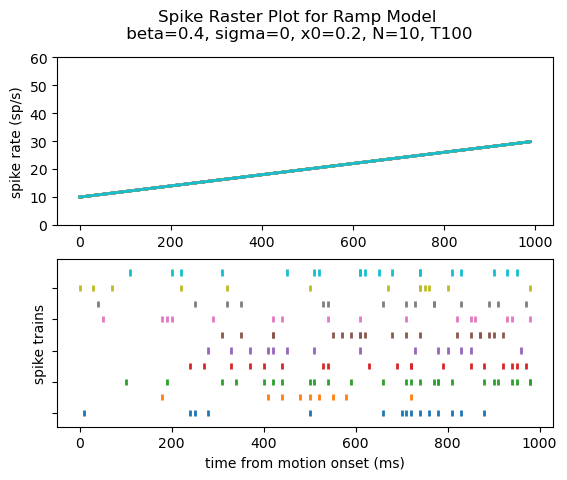

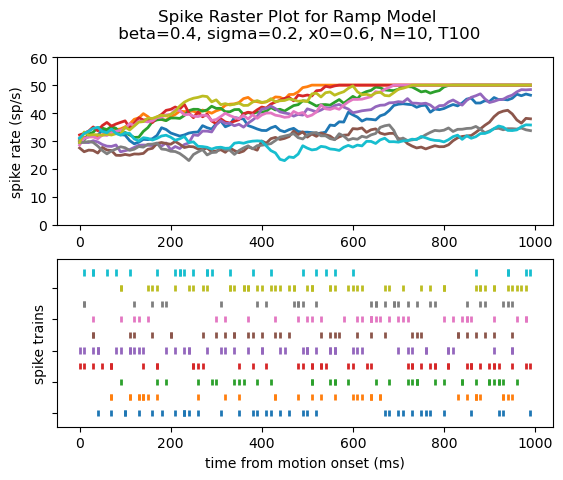

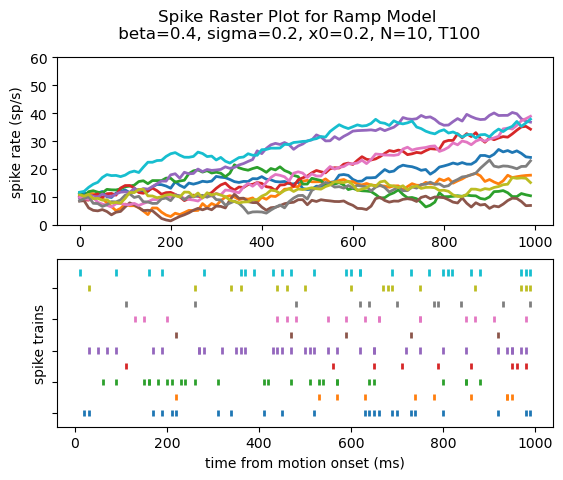

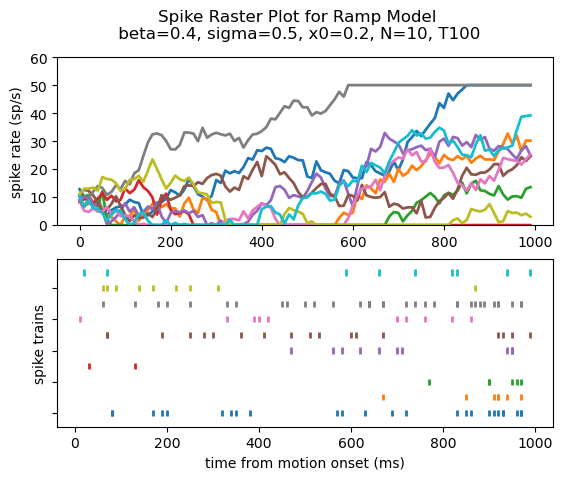

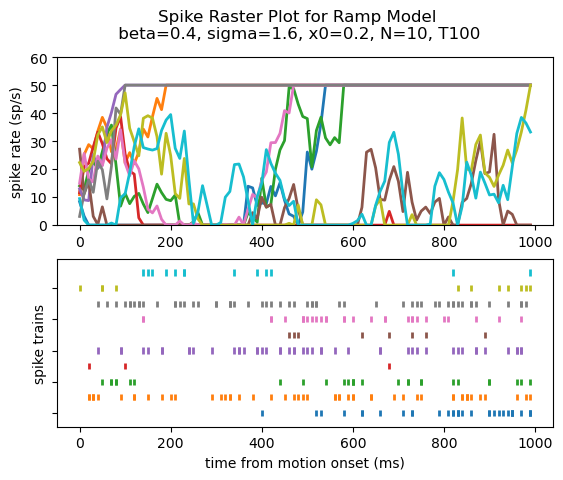

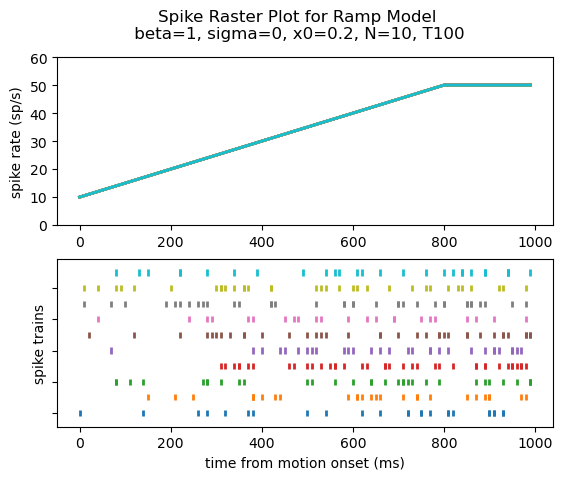

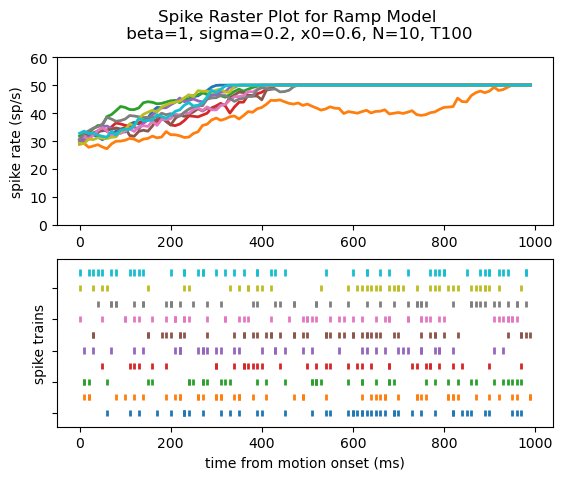

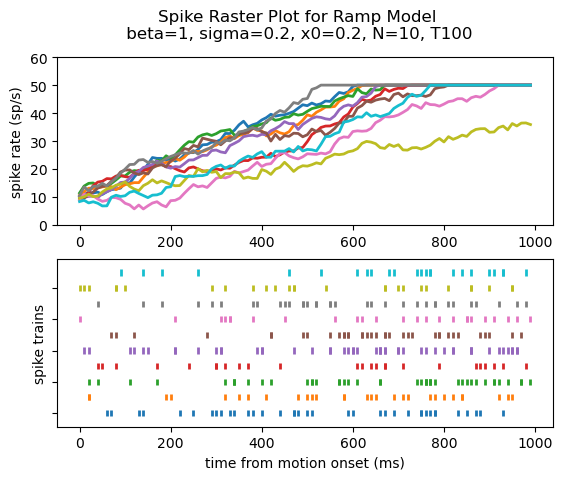

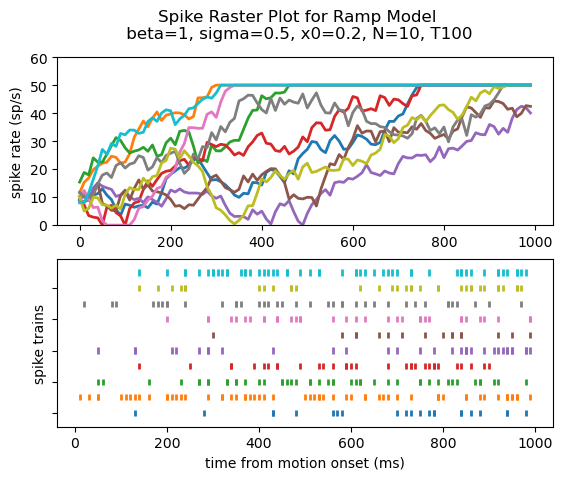

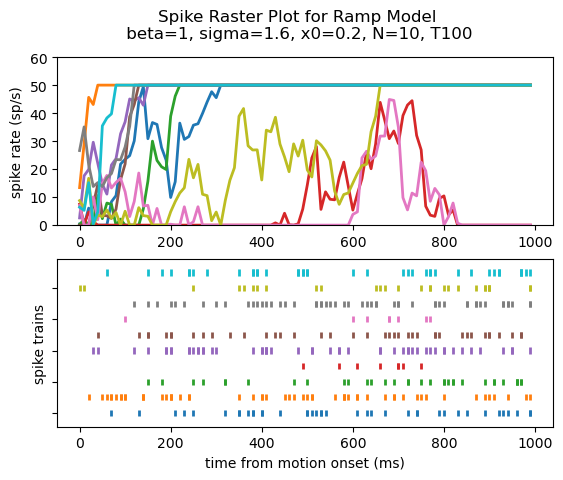

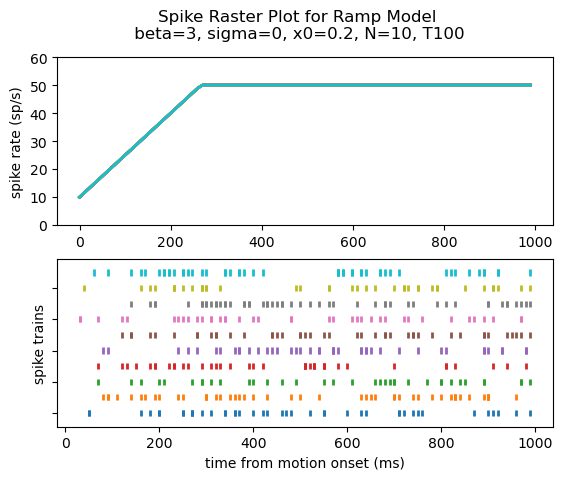

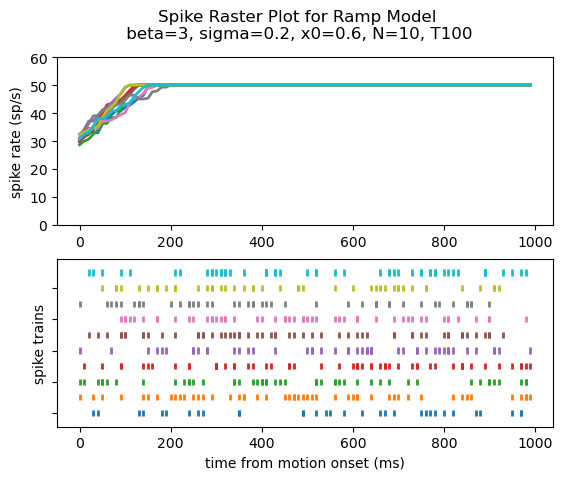

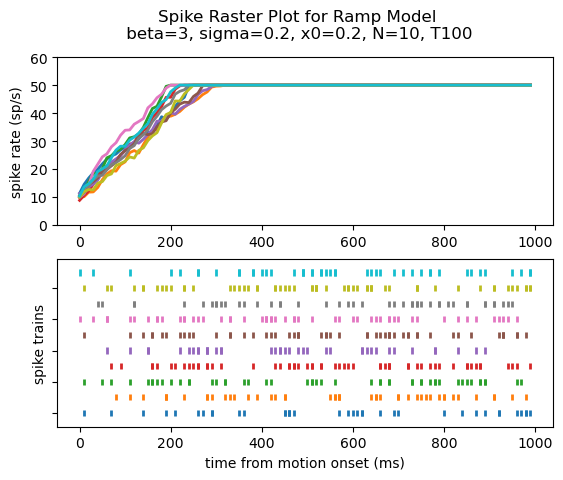

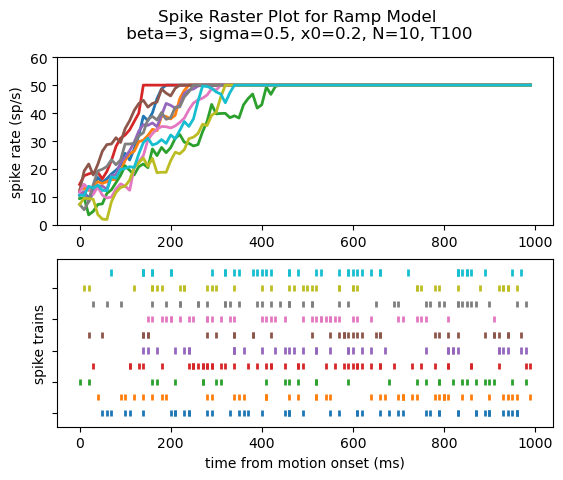

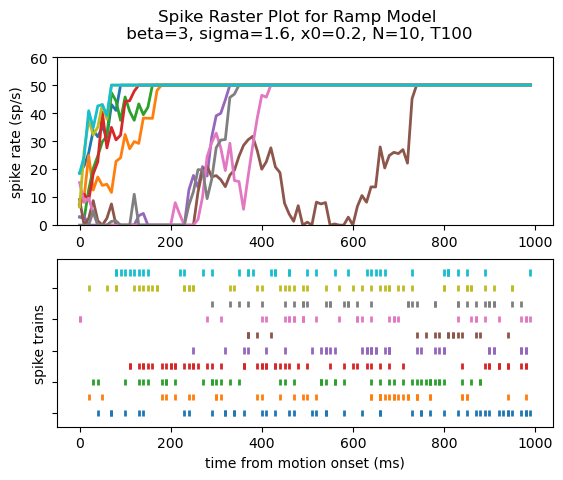

In [6]:
N = 10
for beta in [0.4, 1, 3]:
    for sigma, x0 in [[0,0.2], [0.2, 0.6], [0.2, 0.2], [0.5,0.2],[1.6,0.2]]:

        ramp = RampModel(beta, sigma, x0, Rh=50)
        ramp_arr = ramp.simulate(Ntrials=N, get_rate=True, T = T)

        fig, (ax1, ax2) = plt.subplots(2)
        fig.suptitle(f"Spike Raster Plot for Ramp Model\n beta={beta}, sigma={sigma}, x0={x0}, N={N}, T{T}")

        for i in range(len(ramp_arr[2])):
            ax1.plot(times_ms, ramp_arr[2][i], linewidth = 2)
        ax1.set_ylabel("spike rate (sp/s)")
        ax1.set_ylim(0, 60)

        # record time of spikes in milliseconds
        spike_trains_timestamp = []
        for spike_train in ramp_arr[0]: # for each trail
            timestamp = []
            for i in range(len(spike_train)): # for each time point
                #if spike_train[i]!=0:          # if an spike event occurs at this time stamp
                for j in range(spike_train[i]): # This change is to handle the case where there are multiple spikes in a time stamp
                    timestamp.append(i*1e3/T)
            spike_trains_timestamp.append(timestamp)

        colors1 = ['C{}'.format(i) for i in range(len(ramp_arr[0]))] #set different color for each set of neural data
        ax2.eventplot(spike_trains_timestamp, colors=colors1, linelengths=0.4, linewidths=2)
        ax2.yaxis.set_tick_params(labelleft=False)
        ax2.set_xlabel("time from motion onset (ms)")
        ax2.set_ylabel("spike trains")

        fig.show()

        filename = f"results/1.1/raster_ramp_b{beta}_s{sigma}_x0={x0}_N{N}_T{T}.png"

        # Save the plot
        plt.savefig(filename, bbox_inches='tight')

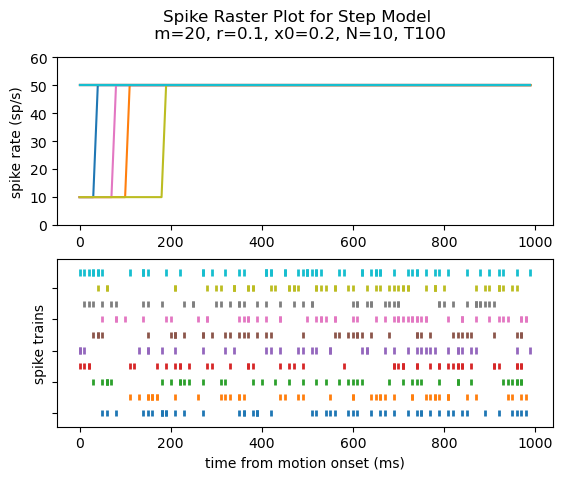

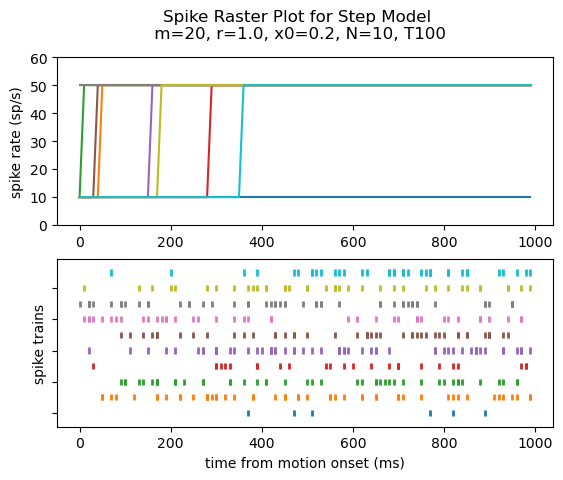

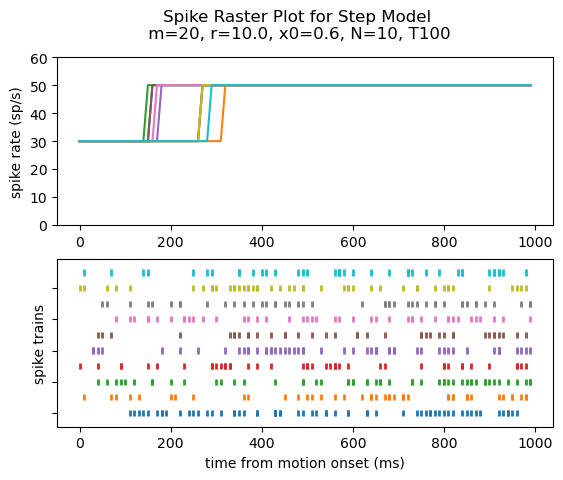

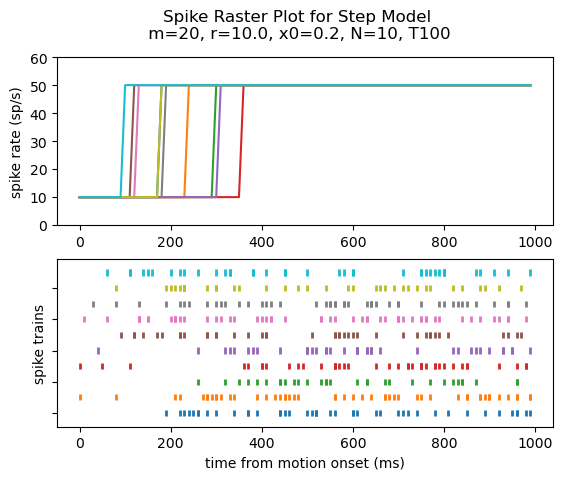

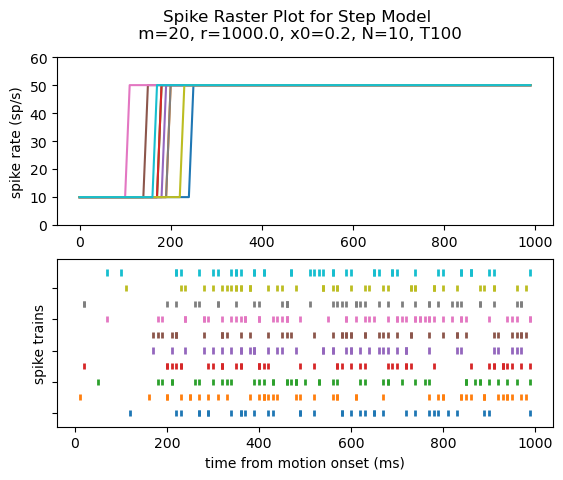

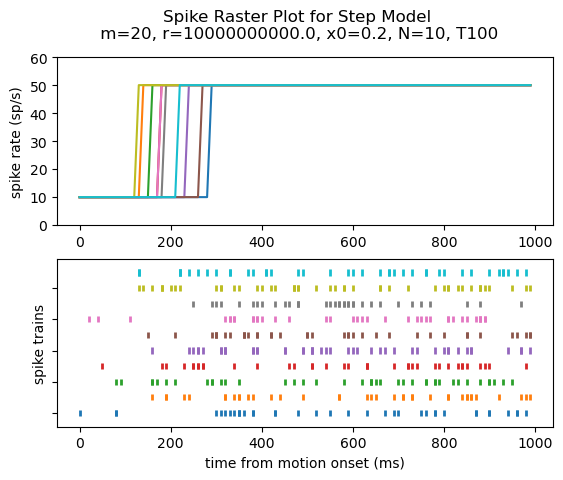

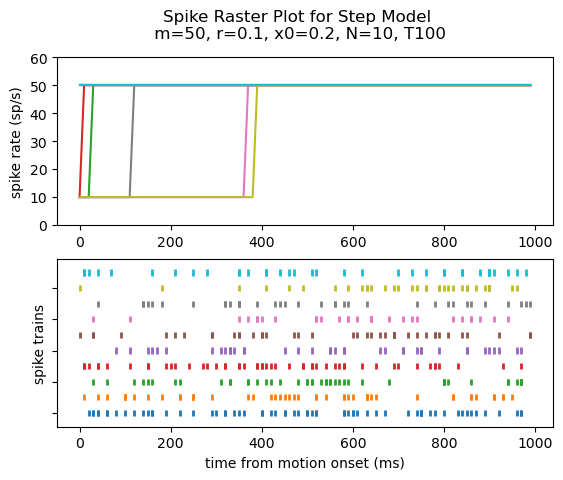

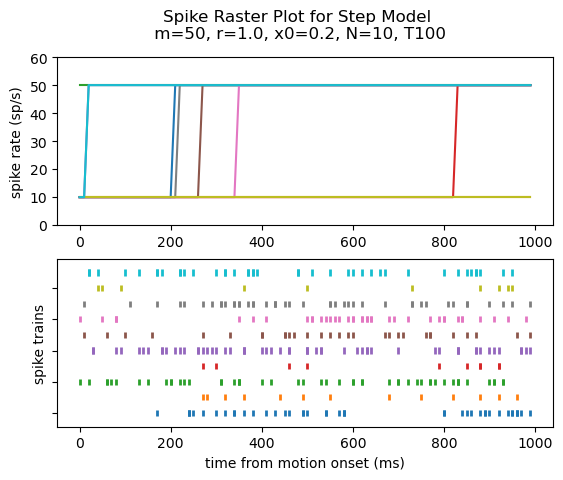

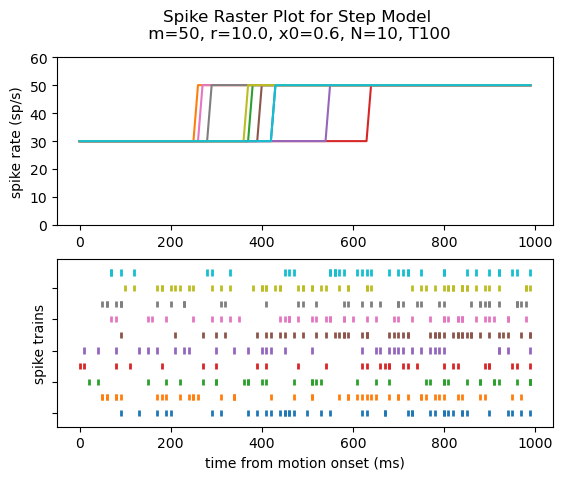

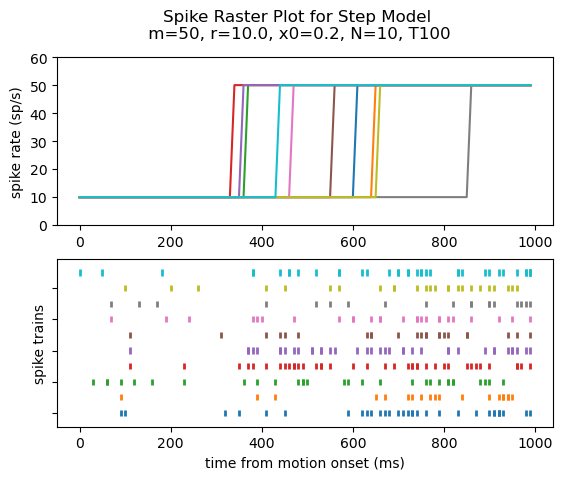

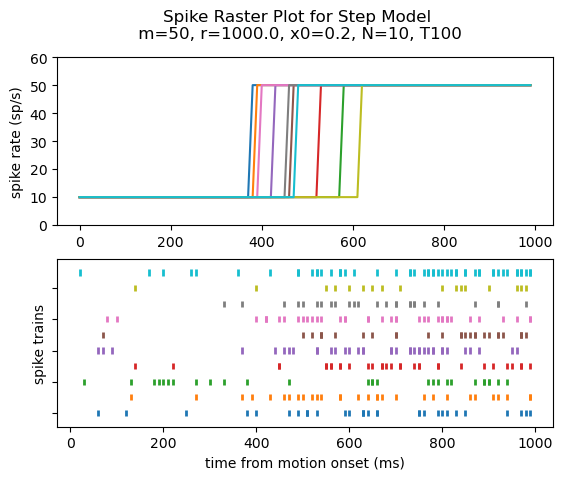

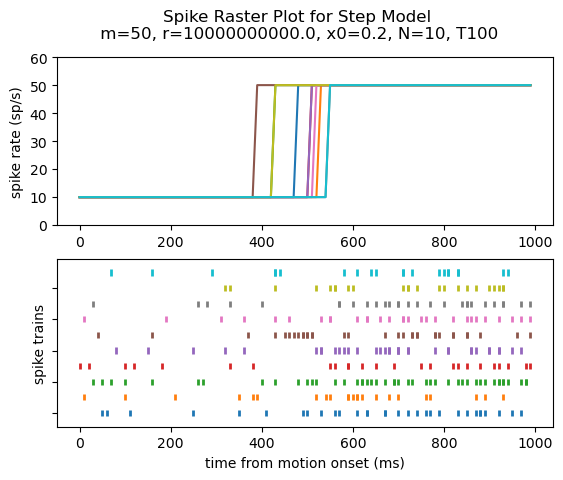

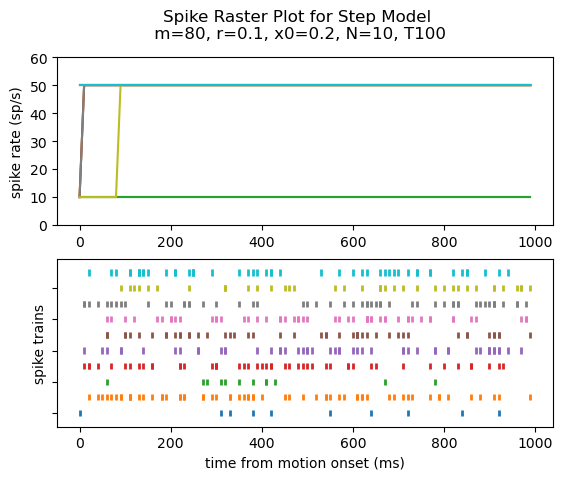

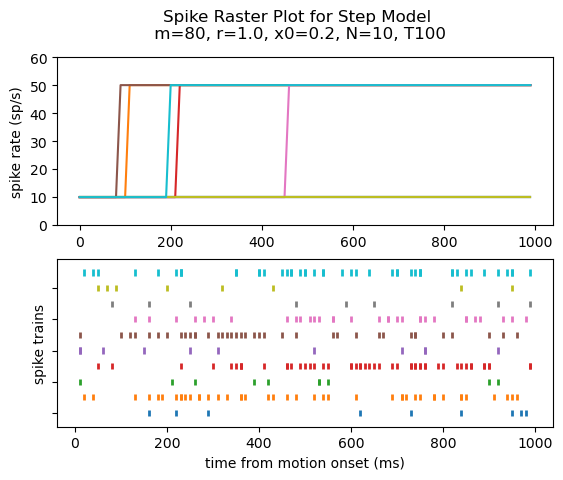

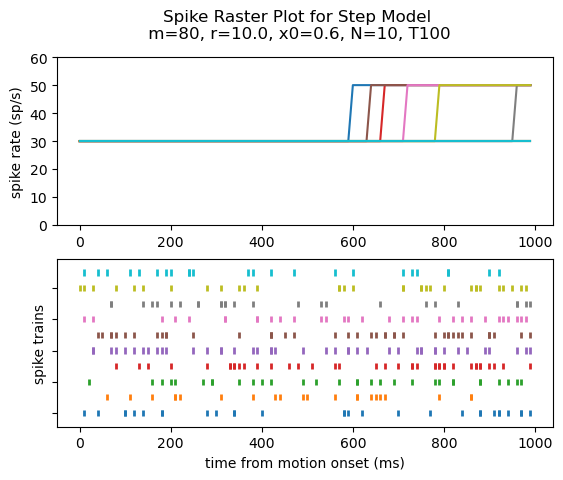

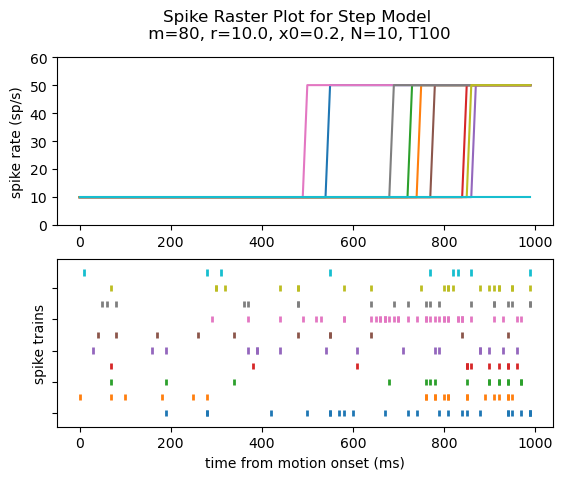

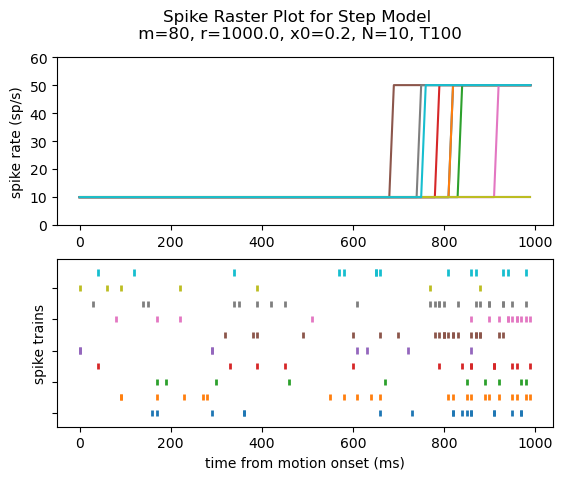

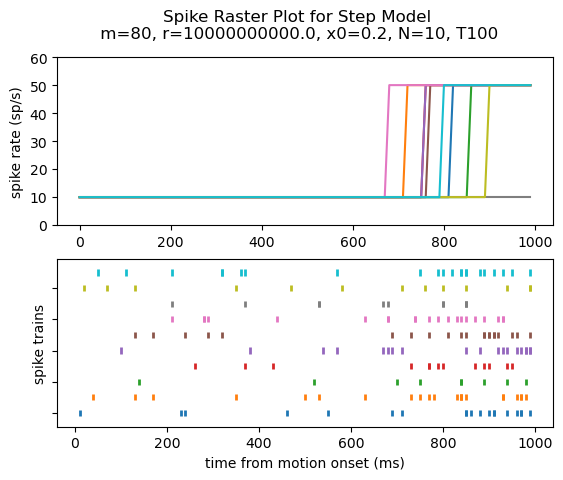

In [7]:
N = 10
for m in [20, 50, 80]:
    for r, x0 in [[1e-1, 0.2], [1e0, 0.2], [1e1, 0.6], [1e1, 0.2], [1e3,0.2],[1e10,0.2]]:
        
        step = StepModel(m, r, x0, Rh=50)
        step_arr = step.simulate(Ntrials=N, get_rate=True, T = T)

        fig, (ax1, ax2) = plt.subplots(2)
        fig.suptitle(plt.hist)

        for i in range(len(step_arr[2])):
            ax1.plot(times_ms, step_arr[2][i])
        ax1.set_ylabel("spike rate (sp/s)")
        ax1.set_ylim(0, 60)

        # record time of spikes in milliseconds
        spike_trains_timestamp = []
        for spike_train in step_arr[0]: # for each trail
            timestamp = []
            for i in range(len(spike_train)):   # for each time point
                #if spike_train[i]!=0:          # if an spike event occurs at this time stamp
                for j in range(spike_train[i]): # This change is to handle the case where there are multiple spikes in a time stamp
                    timestamp.append(i*1e3/T)

            spike_trains_timestamp.append(timestamp)
        colors1 = ['C{}'.format(i) for i in range(len(step_arr[0]))] #set different color for each set of neural data
        ax2.eventplot(spike_trains_timestamp, colors=colors1, linelengths=0.4, linewidths=2)
        ax2.yaxis.set_tick_params(labelleft=False)
        ax2.set_xlabel("time from motion onset (ms)")
        ax2.set_ylabel("spike trains")

        fig.suptitle(f"Spike Raster Plot for Step Model\n m={m}, r={r}, x0={x0}, N={N}, T{T}")
        filename = f"results/1.1/raster_step_m{m}_r{r}_x0={x0}_N{N}_T{T}.png"

        plt.savefig(filename,bbox_inches='tight')
        plt.show()

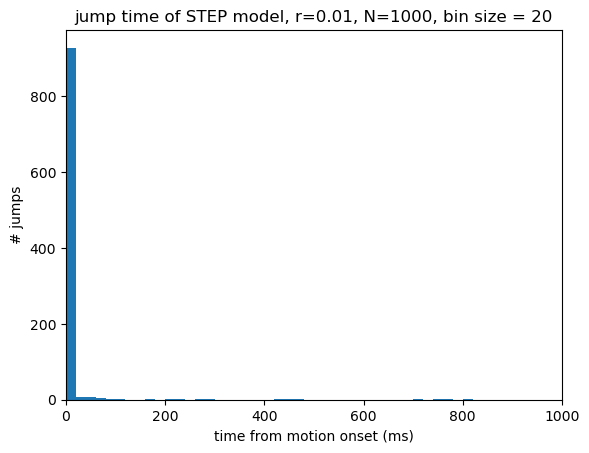

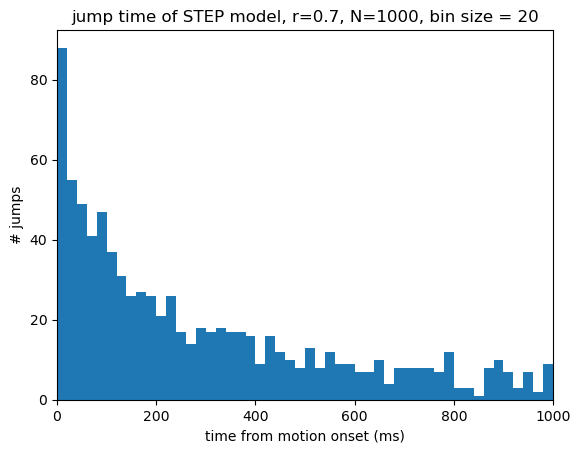

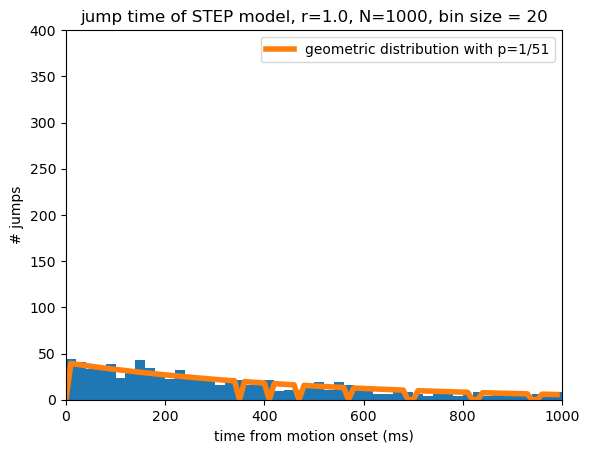

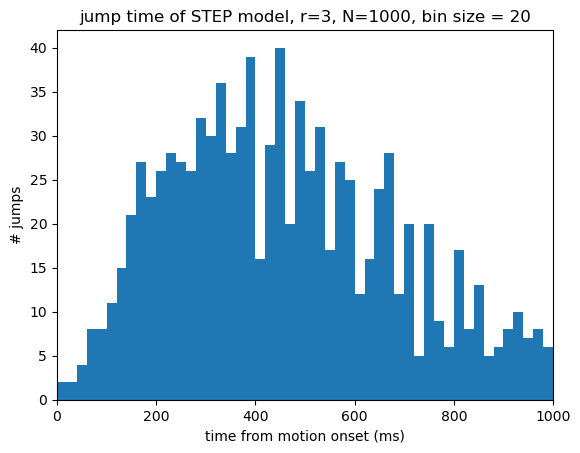

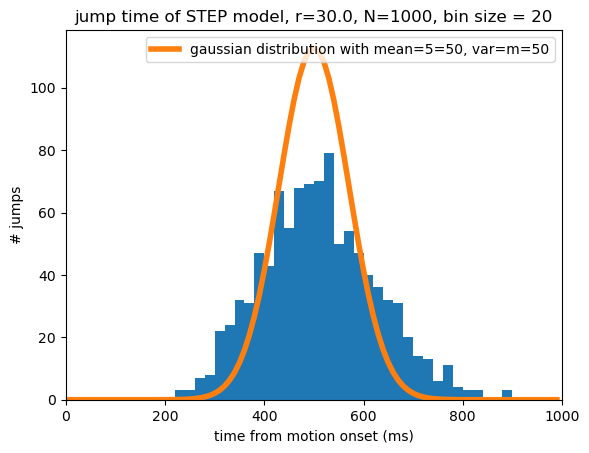

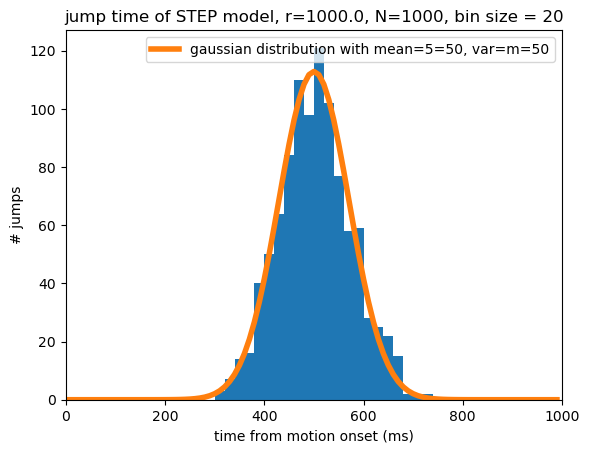

In [8]:
from scipy.stats import geom
from scipy.stats import norm


for r in [1e-2, 0.7, 1e0, 3, 3* 1e1, 1e3]:
    step = StepModel(m=50,r=r, x0=0.2, Rh=50);
    T = 100
    N = 1000
    jump_time = step.simulate(Ntrials=N, get_rate=False, T = T)[1]
    jump_time = jump_time*1e3/T # ms
    plt.hist(jump_time, 50, [0,1000])
    
    if r == 1:
        p = 1/51  # probability of success
        # Calculate binomial distribution
        geometric_distribution = geom.pmf(times_ms/10, p) * 200 * N / T
        plt.ylim(0,400)
        # Create the plot
        plt.plot(times_ms, geometric_distribution, label="geometric distribution with p=1/51", linewidth=4)
        plt.legend()
    if r >= 1e1:
        gaussian_distribution = norm.pdf(times_ms/10, 50, 50**0.5) * 200 * N / T
        # Create the plot
        plt.plot(times_ms, gaussian_distribution, label="gaussian distribution with mean=5=50, var=m=50", linewidth=4)
        plt.legend()

    plt.xlabel("time from motion onset (ms)")
    plt.ylabel("# jumps")
    plt.title(f"jump time of STEP model, r={r}, N=1000, bin size = 20")
    plt.xlim(0,1000)
    filename = f"results/1.1/jumptime_step_r{r}.png"
    plt.savefig(filename,bbox_inches='tight')
    plt.show()


/Users/derek/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


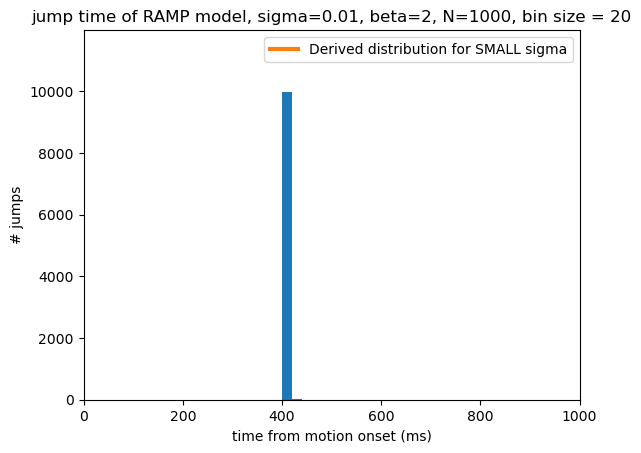

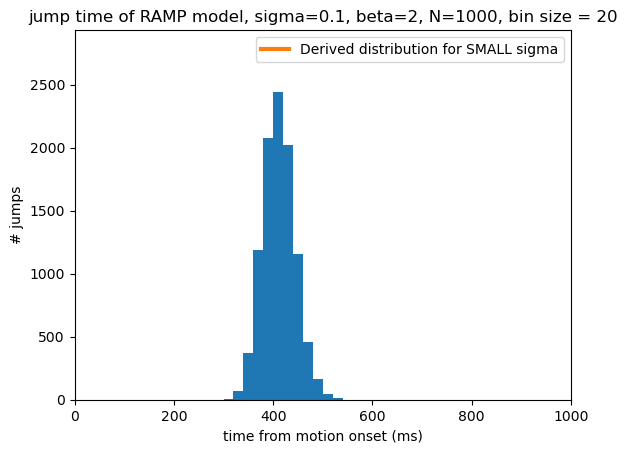

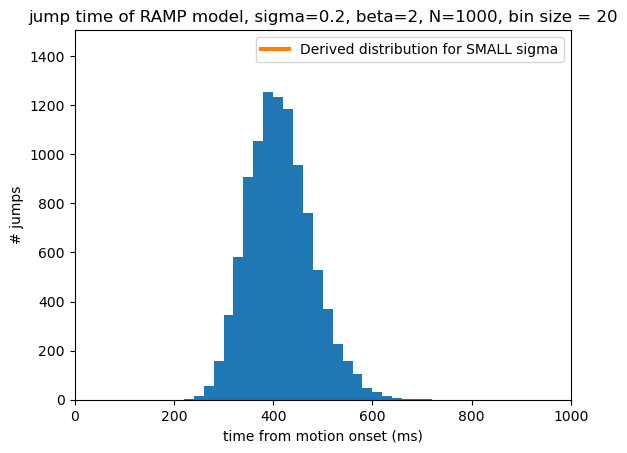

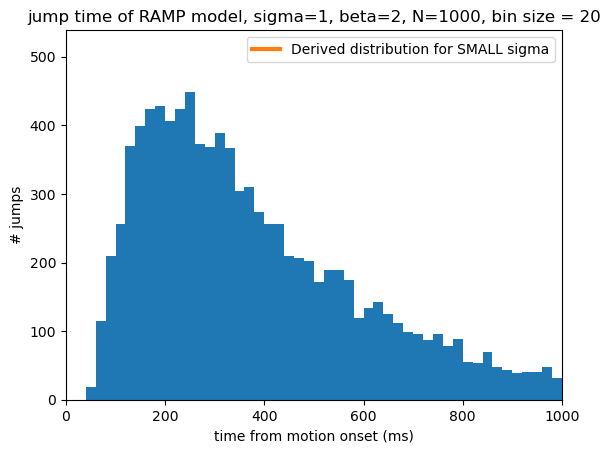

/var/folders/tr/k4p6cxld3ql638sby8p0sr500000gn/T/ipykernel_1934/3413649087.py:34: RuntimeWarning: divide by zero encountered in divide
  gaussian_distribution = norm.pdf((1-0.2)/sigma**2/(times_ms/10), 0, 1) * (1-0.8)/(sigma**2 * (times_ms/10)**2)
/var/folders/tr/k4p6cxld3ql638sby8p0sr500000gn/T/ipykernel_1934/3413649087.py:34: RuntimeWarning: invalid value encountered in divide
  gaussian_distribution = norm.pdf((1-0.2)/sigma**2/(times_ms/10), 0, 1) * (1-0.8)/(sigma**2 * (times_ms/10)**2)


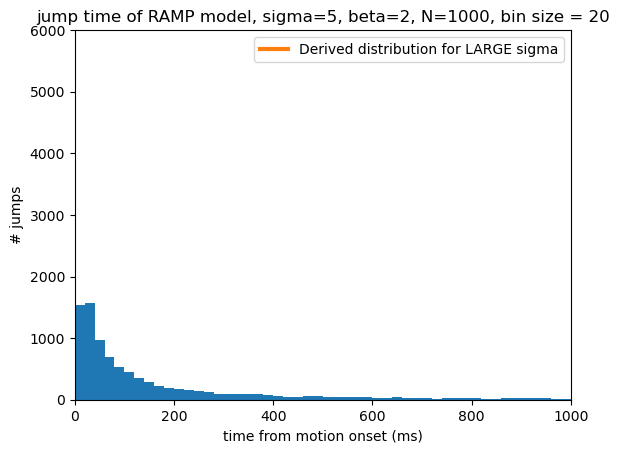

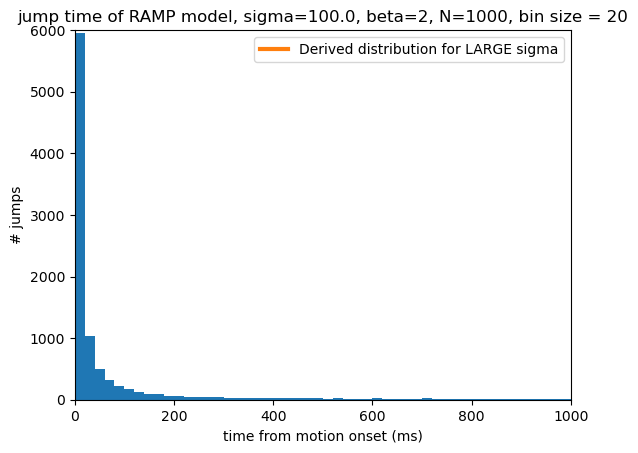

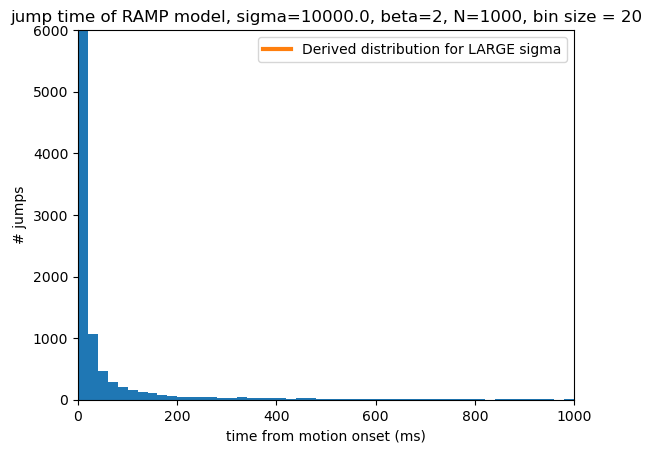

In [9]:
beta = 2
from scipy.stats import skewnorm
from scipy.stats import norm

for sigma in [0.01, 0.1, 0.2, 1, 5, 1e2, 1e4]:

    ramp = RampModel(beta=beta, sigma=sigma, x0=.2, Rh=50)
    T = 100
    N = 10000
    X = ramp.simulate(Ntrials=N, get_rate=False, T = T)[1]
    max_time = []
    for x in X:
        for i in range(T):
            if x[i] == 1.0:
                max_time.append(i*1e3/T)
                break
    hist , _, _ = plt.hist(max_time, 50, [0,1000])

    if sigma <= 1:

        tau = 0.8/beta
        gaussian_distribution = norm.pdf((0.8-beta*(times_ms/1000)), 0, sigma* (times_ms/1000)**0.5)
        normalised = gaussian_distribution / np.sum(gaussian_distribution) * 200 * N / T
        # Create the plot
        plt.plot(times_ms, normalised, label="Derived distribution for SMALL sigma", linewidth=3)
        plt.legend()
        plt.ylim(0,np.max(hist) * 1.2)

        
        
    if sigma >= 5:

        tau = 0.8/beta
        gaussian_distribution = norm.pdf((1-0.2)/sigma**2/(times_ms/10), 0, 1) * (1-0.8)/(sigma**2 * (times_ms/10)**2)
        normalised = gaussian_distribution / np.sum(gaussian_distribution) * 200 * N / T

        # Create the plot
        plt.plot(times_ms, normalised, label="Derived distribution for LARGE sigma", linewidth=3)
        plt.legend()
        plt.ylim(0,6000)


    plt.xlabel("time from motion onset (ms)")
    plt.ylabel("# jumps")
    plt.title(f"jump time of RAMP model, sigma={sigma}, beta={beta}, N=1000, bin size = 20")
    plt.xlim(0,1000)
    filename = f"results/1.1/jumptime_RAMP_s{sigma}_beta{beta}.png"
    plt.savefig(filename,bbox_inches='tight')
    plt.show()


### Task 1.2

PSTH is an important data analysis tool used in neuroscience.<br> 
This  is a statistical estimate of the trial-averaged firing rate as a function of time, based on recordings of spike trains in<br>
multiple experimental trials. It is obtained by binning/histogramming spikes (e.g. using `np.histogram`) in different time bins<br>
and averaging the resulting spike counts over many trials (you can also divide by `dt` to turn into rate in units of Hz).<br>

**Write code to construct and plot PSTH's in different regions of each model's parameter space.** Note how the PSTH <br>
fluctuates randomly from dataset to dataset. **It is better to do some sort of (temporal) smoothing in order to reduce these<br>**
fluctuations and the jaggedness of the PSTH. You can use either a sliding window (e.g. a boxcar window/functin) averaging, or simply <br>
use time bins that are larger than the oridinal time steps (e.g. 50 milliseconds -- or 5 timesteps if you are using a `dt` of 10 ms,<br> 
corresponding to `T = 100`). The smooth ramping firing rate curves in Figure 4 of the [Background](https://github.com/ahmadianlab/gg3_nda/blob/main/Background.ipynb)
are examples of smoothed PSTH's.

Even with the smoothing there will be fluctuations in the PSTH from dataset to dataset. **How does the strength of these fluctuations <br>depend on (or scale with) the number of trials (in each dataset)? Try to be quantitative about this, e.g. by using informed plots. <br>**
For the rest of this task use a high number of trials (e.g. 5000) to minimise these fluctuations. (But note <br>
that in real experiments the number of trials rarely exceeds a few hundred -- for for later tasks we will bring the number down.)


Finally, **try to find parameter regimes that make the PSTH of the stepping model very close to that of the ramp model. (First make sure<br>
the ramp model's PSTH look qualitatively like the classic ramping PSTH's in LIP experiments.) In which parameter regions<br>
does this fail drastically, and in which regimes are the two PSTH's nearly indistinguishable?**

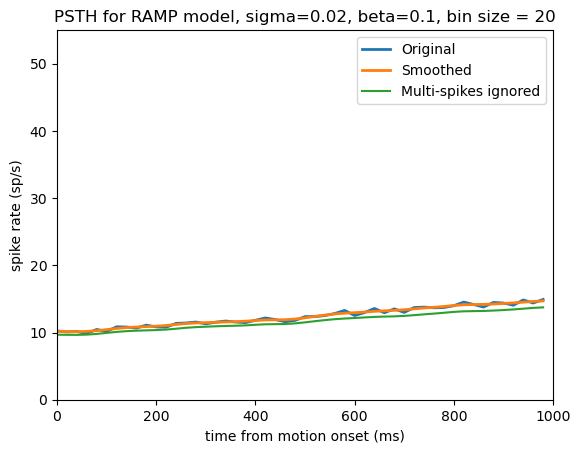

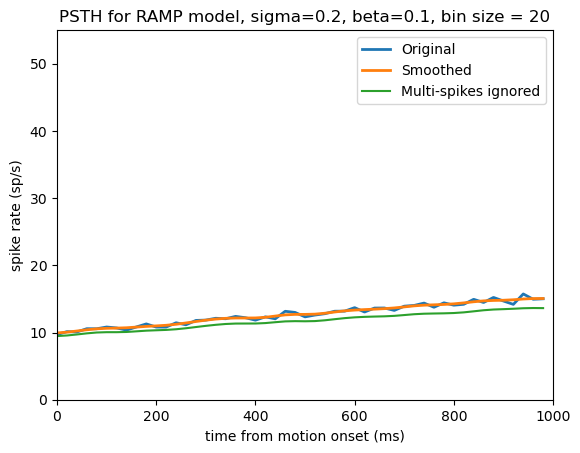

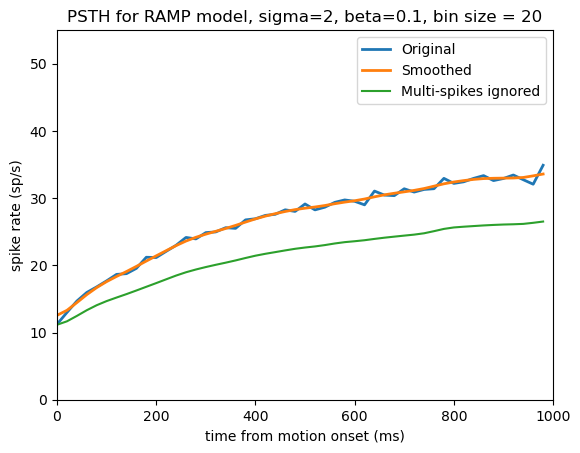

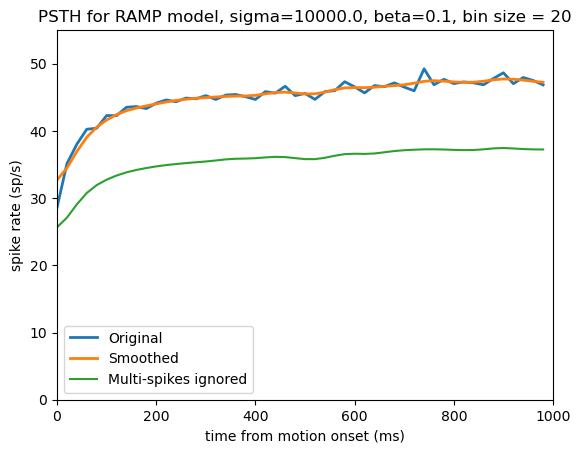

KeyboardInterrupt: 

In [10]:
beta_list = [0.1, 0.5, 1]
sigma_list = [0.02, 0.2, 2, 1e4]
from models import *
from models2 import *
for b in beta_list:
    for s in sigma_list:
        
        ramp = RampModel(beta=b, sigma=s, x0=.2, Rh=50)
        T = 100
        N = 5000
        ramp_arr = ramp.simulate(Ntrials=N, get_rate=False, T = T)
        bin_size = 20
        bin_edges = np.arange(0, 1e3+bin_size, bin_size)

        ## this method considers the multi-spike issue ##
        averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=ramp_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);

        
        # record time of spikes in milliseconds
        spike_trains_timestamp = []
        for spike_train in ramp_arr[0]:
            timestamp = []
            for i in range(len(spike_train)):
                ## this method ignores the multi-spike issue ##
                if spike_train[i]!=0: 
                    timestamp.append(i*1e3/T)
            spike_trains_timestamp.append(timestamp)

        # Calculate the PSTH
        psth_ignore, _ = np.histogram(np.concatenate(spike_trains_timestamp), bins=bin_edges)

        from scipy.ndimage import gaussian_filter
        sigma = 1.5 # Standard deviation of the Gaussian filter
        smoothed_psth_ignore = gaussian_filter((psth_ignore / bin_size * 1e3) / N, sigma)
        
        
        # Plot the PSTH
        plt.plot(bin_edges[:-1], averaged_psth,  label='Original', linewidth = 2)
        plt.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='Smoothed', linewidth = 2)
        plt.plot(bin_edges[:-1], smoothed_psth_ignore,  label='Multi-spikes ignored', linewidth = 1.5)

        plt.ylabel("spike rate (sp/s)")
        plt.xlabel("time from motion onset (ms)")
        plt.ylim(0,55)
        plt.xlim(0,1000)
        plt.legend()
        
        plt.title(f"PSTH for RAMP model, sigma={s}, beta={b}, bin size = 20")
        filename = f"results/1.2/PSTH_RAMP_s{s}_beta{b}.png"
        plt.savefig(filename,bbox_inches='tight')
        plt.show()

In [ ]:
m_list = [10,50,90]
r_list = [1, 10, 100]
for m in m_list:
    for r in r_list:
        step = StepModel(m=m, r=r, x0=0.2, Rh=50)
        T = 100
        N = 5000
        step_arr = step.simulate(Ntrials=N, get_rate=False, T = T)
        bin_size=20
        bin_edges = np.arange(0, 1e3+bin_size, bin_size)
        
        ## this method considers the multi-spike issue ##
        averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=step_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);

        # record time of spikes in milliseconds
        spike_trains_timestamp = []
        for spike_train in step_arr[0]:
            timestamp = []
            for i in range(len(spike_train)):
                ## this method ignores the multi-spike issue ##
                if spike_train[i]!=0: 
                    timestamp.append(i*1e3/T)
            spike_trains_timestamp.append(timestamp)

        # Calculate the PSTH
        psth_ignore, _ = np.histogram(np.concatenate(spike_trains_timestamp), bins=bin_edges)

        from scipy.ndimage import gaussian_filter
        sigma = 1.5 # Standard deviation of the Gaussian filter
        smoothed_psth_ignore = gaussian_filter((psth_ignore / bin_size * 1e3) / N, sigma)
        
        
        # Plot the PSTH
        plt.plot(bin_edges[:-1], averaged_psth,  label='Original', linewidth = 2)
        plt.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='Smoothed', linewidth = 2)
        plt.plot(bin_edges[:-1], smoothed_psth_ignore,  label='Multi-spikes ignored', linewidth = 1.5)

        plt.ylabel("spike rate (sp/s)")
        plt.xlabel("time from motion onset (ms)")
        
        plt.legend()
        plt.ylim(0,55)  
        plt.title(f"PSTH for STEP model, r={r}, m={m}, bin size = 20")
        plt.xlim(0,1000)
        filename = f"results/1.2/PSTH_STEP_r{r}_m{m}.png"
        plt.savefig(filename,bbox_inches='tight')

        plt.show()

In [ ]:
# How does the strength of fluctuations depend on the number of trials?
b=0.5
s=0.2

m=50
r=0.2
ramp = RampModel(beta=0.5, sigma=0.2, x0=.2, Rh=50)
step = StepModel(m=m, r=r, x0=0.2, Rh=50)
T = 100

bin_size=20
bin_edges = np.arange(0, 1e3+bin_size, bin_size)
bin_size_2=50
bin_edges_2 = np.arange(0, 1e3+bin_size_2, bin_size_2)    

number_of_trails = [10, 100, 1000, 10000]
number_of_dataset = 10
psth_s = np.empty((number_of_dataset,int(1000/bin_size) ))

for n in number_of_trails:
    for ii in range(number_of_dataset):
        arr = ramp.simulate(Ntrials=n, get_rate=False, T = T)

        averaged_psth, gaussian_smoothed_psth, var_s, _ = generate_psth(spike_trains=arr[0], bin_size=bin_size, bin_size_2=bin_size_2, plot=False);
        psth_s[ii] = gaussian_smoothed_psth

    var = np.var(psth_s, axis=0)

    plt.plot(bin_edges[:-1], var,  label=f"# trials = {n}", linewidth = 2)

plt.ylabel("variance")
plt.yscale("log")
plt.xlabel("time from motion onset (ms)")
plt.legend()
plt.title(f"PSTH fluctuations vs the number of trials (ramp model)")
filename = f"results/1.2/fluctuations_PSTH_ramp.png"
plt.savefig(filename,bbox_inches='tight')
plt.show()


In [ ]:
# Quantifying the fluctuation with average variance

# Gives average variance over 10 datasets of Ramp Model with beta = 0.5 and sigma = 0.2 and given number of trials
def get_average_variance(N):
    ramp = RampModel(beta=0.5, sigma=0.2, x0=.2, Rh=50)
    T = 100
    # N = 50
    number_of_dataset = 10
    psth_list = []
    for _ in range(number_of_dataset):
        ramp_arr = ramp.simulate(Ntrials=N, get_rate=False, T = T)

        # record time of spikes in milliseconds
        spike_trains_timestamp = []
        for spike_train in ramp_arr[0]:
            timestamp = []
            for i in range(len(spike_train)):
                if spike_train[i]!=0:
                    timestamp.append(i*1e3/T)
            spike_trains_timestamp.append(timestamp)

        # Calculate the PSTH
        bin_size = 20  # Choose an appropriate bin size for the PSTH (in milliseconds)
        bin_edges = np.arange(0, 1e3+bin_size, bin_size)
        psth, _ = np.histogram(np.concatenate(spike_trains_timestamp), bins=bin_edges)

        averaged_psth = (psth / bin_size * 1e3) / N # spikes per sec per trail

        from scipy.ndimage import gaussian_filter
        sigma = 1.5 # Standard deviation of the Gaussian filter

        # Apply Gaussian smoothing
        gaussian_smoothed_psth = gaussian_filter(averaged_psth, sigma)

        psth_list.append(gaussian_smoothed_psth)

    variance = []
    for i in range(len(psth_list[0])):
        data = []
        for psth in psth_list:
            data.append(psth[i])
        variance.append(np.var(data))
    average_variance = np.average(variance)
    return average_variance
n_trials = np.linspace(50,5000,50)
avg_var = [get_average_variance(int(n)) for n in n_trials]
plt.plot(n_trials, avg_var, linewidth = 2)
plt.xlabel("Number of trials")
plt.ylabel("Average variance (log-scale)")

plt.yscale("log")
plt.legend()
plt.title(f"PSTH fluctuations vs the number of trials")
filename = f"results/1.2/fluctuations_PSTH.png"
plt.savefig(filename,bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Indistinguishable regime 1

T = 100
N = 4000
time_points = np.arange(T)  # 0,1,2,...
dt = 1/T
times_ms = time_points * dt * 1e3
b = 1
m = 50
r = 0.001
s = 1e4
x_r = 0.3
x_s = 0.15

sigma = 1.5

fig, ax2 = plt.subplots() # ax2 is for jump time hist
ax1 = ax2.twinx() # ax2 is for PSTH

bin_size=20
bin_edges = np.arange(0, 1e3+bin_size, bin_size)
bin_size_2=50
bin_edges_2 = np.arange(0, 1e3+bin_size_2, bin_size_2)   

#step model
step = StepModel(m=m, r=r, x0=x_s, Rh=50)
step_arr = step.simulate(Ntrials=N, get_rate=False, T = T)
averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=step_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);
grad_step = np.gradient(gaussian_smoothed_psth, 1/50)
ax1.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='step model psth', linewidth=2, color='#1f77b4')# Light Blue


#ramp model
ramp = RampModel(beta=b, sigma=s, x0=x_r, Rh=50)
ramp_arr = ramp.simulate(Ntrials=N, get_rate=False, T = T)
averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=ramp_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);
grad_ramp = np.gradient(gaussian_smoothed_psth, 1/50)
ax1.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='ramp model psth',linewidth=2, color='#ff7f0e')  # Light Orange



#step jump time distribution
jump_time = step_arr[1]
jump_time = jump_time*1e3/T # ms
ax2.hist(jump_time, 50, [0,1000], label="step model jump times", color='#2ca02c')  # Dark Blue

    
#ramp jump time distribution
X = ramp_arr[1]
max_time = []
for x in X:
    for i in range(T):
        if x[i] == 1.0:
            max_time.append(i*1e3/T)
            break
hist , _, _ = ax2.hist(max_time, 50, [0,1000], label="ramp model jump times", color='#d62728')  # Dark Orange

ax2.set_ylabel("# jumps")


ax1.set_ylabel("spike rate (sp/s)")
ax1.set_xlabel("time from motion onset (ms)")
ax1.set_ylim(0,55)

ax1.set_title(f"Regime 1\n r={r}, m={m}, Xs={x_s}, s={s}, beta={b}, Xr={x_r}")
filename = f"results/1.2/similar_step_ramp.png"
ax2.set_xlabel("time from motion onset (ms)")
ax2.set_xlim(0,1000)
fig.legend(loc=(0.55, 0.14))


filename = f"results/1.2/Similar models, regime, r={r}, m={m}, s={s}, beta={b}.png"
plt.savefig(filename,bbox_inches='tight')



In [ ]:
## Indistinguishable regime 2 (counter)

T = 100
N = 4000
time_points = np.arange(T)  # 0,1,2,...
dt = 1/T
times_ms = time_points * dt * 1e3
b = 1
m = 50
r = 1e4
s = 0.01
x_r = 0.3
x_s = 0.15
m=(1-x_r)/(b) * T
print(m)

sigma = 1.5 #gaussian filter

fig, ax2 = plt.subplots() # ax2 is for jump time hist
ax1 = ax2.twinx() # ax2 is for PSTH

bin_size=20
bin_edges = np.arange(0, 1e3+bin_size, bin_size)
bin_size_2=50
bin_edges_2 = np.arange(0, 1e3+bin_size_2, bin_size_2)   

#step model
step = StepModel(m=m, r=r, x0=x_s, Rh=50)
step_arr = step.simulate(Ntrials=N, get_rate=False, T = T)
averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=step_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);
grad_step = np.gradient(gaussian_smoothed_psth, 1/50)
ax1.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='step model psth', linewidth=2, color='#1f77b4')# Light Blue


#ramp model
ramp = RampModel(beta=b, sigma=s, x0=x_r, Rh=50)
ramp_arr = ramp.simulate(Ntrials=N, get_rate=False, T = T)
averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=ramp_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);
grad_ramp = np.gradient(gaussian_smoothed_psth, 1/50)
ax1.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='ramp model psth',linewidth=2, color='#ff7f0e')  # Light Orange



#step jump time distribution
jump_time = step_arr[1]
jump_time = jump_time*1e3/T # ms
ax2.hist(jump_time, 50, [0,1000], label="step model jump times", color='#2ca02c')  # Dark Blue

    
#ramp jump time distribution
X = ramp_arr[1]
max_time = []
for x in X:
    for i in range(T):
        if x[i] == 1.0:
            max_time.append(i*1e3/T)
            break
hist , _, _ = ax2.hist(max_time, 50, [0,1000], label="ramp model jump times", color='#d62728')  # Dark Orange

ax2.set_ylabel("# jumps")


ax1.set_ylabel("spike rate (sp/s)")
ax1.set_xlabel("time from motion onset (ms)")
ax1.set_ylim(0,55)

ax1.set_title(f"Regime 2 (counter-example)\n r={r}, m={m}, s={s}, X_s={x_s} beta={b}, Xr={x_r}")
filename = f"results/1.2/similar_step_ramp.png"
ax2.set_xlabel("time from motion onset (ms)")
ax2.set_xlim(0,1000)
fig.legend(loc=(0.15, 0.67))


filename = f"results/1.2/Similar models, regime 2, r={r}, m={m}, s={s}, beta={b}(regime 2)(beta not sufficiently large).png"
plt.savefig(filename,bbox_inches='tight')



In [ ]:
## Indistinguishable regime 2

T = 100
N = 4000
time_points = np.arange(T)  # 0,1,2,...
dt = 1/T
times_ms = time_points * dt * 1e3
b = 50
m = 50
r = 1e4
s = 0.01
x_r = 0.3
x_s = 0.15
m=(1-x_r)/(b) * T
print(m)

sigma = 1.5 #gaussian filter

fig, ax2 = plt.subplots() # ax2 is for jump time hist
ax1 = ax2.twinx() # ax2 is for PSTH

bin_size=20
bin_edges = np.arange(0, 1e3+bin_size, bin_size)
bin_size_2=50
bin_edges_2 = np.arange(0, 1e3+bin_size_2, bin_size_2)   

#step model
step = StepModel(m=m, r=r, x0=x_s, Rh=50)
step_arr = step.simulate(Ntrials=N, get_rate=False, T = T)
averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=step_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);
grad_step = np.gradient(gaussian_smoothed_psth, 1/50)
ax1.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='step model psth', linewidth=2, color='#1f77b4')# Light Blue


#ramp model
ramp = RampModel(beta=b, sigma=s, x0=x_r, Rh=50)
ramp_arr = ramp.simulate(Ntrials=N, get_rate=False, T = T)
averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=ramp_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);
grad_ramp = np.gradient(gaussian_smoothed_psth, 1/50)
ax1.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='ramp model psth',linewidth=2, color='#ff7f0e')  # Light Orange



#step jump time distribution
jump_time = step_arr[1]
jump_time = jump_time*1e3/T # ms
ax2.hist(jump_time, 50, [0,1000], label="step model jump times", color='#2ca02c')  # Dark Blue

    
#ramp jump time distribution
X = ramp_arr[1]
max_time = []
for x in X:
    for i in range(T):
        if x[i] == 1.0:
            max_time.append(i*1e3/T)
            break
hist , _, _ = ax2.hist(max_time, 50, [0,1000], label="ramp model jump times", color='#d62728')  # Dark Orange

ax2.set_ylabel("# jumps")


ax1.set_ylabel("spike rate (sp/s)")
ax1.set_xlabel("time from motion onset (ms)")
ax1.set_ylim(0,55)

ax1.set_title(f"Regime 2 \n r={r}, m={m}, s={s}, X_s={x_s} beta={b}, Xr={x_r}")
filename = f"results/1.2/similar_step_ramp.png"
ax2.set_xlabel("time from motion onset (ms)")
ax2.set_xlim(0,1000)
fig.legend(loc=(0.55, 0.14))


filename = f"results/1.2/Similar models, regime 2, r={r}, m={m}, s={s}, beta={b}(regime 2).png"
plt.savefig(filename,bbox_inches='tight')



In [ ]:
## Indistinguishable regime 3

T = 100
N = 4000
time_points = np.arange(T)  # 0,1,2,...
dt = 1/T
times_ms = time_points * dt * 1e3
b = 1
r = 2
s = 1.1
x_r = 0.3
x_s = 0.15
m=(1-x_r)/(2*b) * T
print(m)

sigma = 1.5 #gaussian filter

fig, ax2 = plt.subplots() # ax2 is for jump time hist
ax1 = ax2.twinx() # ax2 is for PSTH

bin_size=20
bin_edges = np.arange(0, 1e3+bin_size, bin_size)
bin_size_2=50
bin_edges_2 = np.arange(0, 1e3+bin_size_2, bin_size_2)   

#step model
step = StepModel(m=m, r=r, x0=x_s, Rh=50)
step_arr = step.simulate(Ntrials=N, get_rate=False, T = T)
averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=step_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);
grad_step = np.gradient(gaussian_smoothed_psth, 1/50)
ax1.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='step model psth', linewidth=2, color='#1f77b4')# Light Blue


#ramp model
ramp = RampModel(beta=b, sigma=s, x0=x_r, Rh=50)
ramp_arr = ramp.simulate(Ntrials=N, get_rate=False, T = T)
averaged_psth, gaussian_smoothed_psth, _, _ = generate_psth(spike_trains=ramp_arr[0], bin_size=bin_size, bin_size_2=50, plot=False);
grad_ramp = np.gradient(gaussian_smoothed_psth, 1/50)
ax1.plot(bin_edges[:-1], gaussian_smoothed_psth,  label='ramp model psth',linewidth=2, color='#ff7f0e')  # Light Orange



#step jump time distribution
jump_time = step_arr[1]
jump_time = jump_time*1e3/T # ms
ax2.hist(jump_time, 50, [0,1000], label="step model jump times", color='#2ca02c')  # Dark Blue

    
#ramp jump time distribution
X = ramp_arr[1]
max_time = []
for x in X:
    for i in range(T):
        if x[i] == 1.0:
            max_time.append(i*1e3/T)
            break
hist , _, _ = ax2.hist(max_time, 50, [0,1000], label="ramp model jump times", color='#d62728')  # Dark Orange

ax2.set_ylabel("# jumps")


ax1.set_ylabel("spike rate (sp/s)")
ax1.set_xlabel("time from motion onset (ms)")
ax1.set_ylim(0,55)

ax1.set_title(f"Regime 3 \n r={r}, m={m}, s={s}, X_s={x_s} beta={b}, Xr={x_r}")
filename = f"results/1.2/similar_step_ramp.png"
ax2.set_xlabel("time from motion onset (ms)")
ax2.set_xlim(0,1000)
fig.legend(loc=(0.55, 0.14))


filename = f"results/1.2/Similar models, regime 3, r={r}, m={m}, s={s}, beta={b}(regime 2).png"
plt.savefig(filename,bbox_inches='tight')

In [ ]:
# Parameters
N = 4000
T = 100
time_points = np.arange(T)  # 0,1,2,...
dt = 1/T
times_ms = time_points * dt * 1e3
beta = 1.5
m = 0.8/beta * 100

# Define the distributions
def distribution_1(sigma):
    return norm.pdf(times_ms/10, m, m**0.5) * 200 * N / T

def distribution_2(sigma):
    dist = norm.pdf((0.8-beta*(times_ms/1000)), 0, sigma * (times_ms/1000)**0.5)
    return dist / np.sum(dist) * 200 * N / T

# Calculate variances
sigmas = np.linspace(0.1, 0.5, 100)
variances_1 = [np.var(distribution_1(sigma)) for sigma in sigmas]
variances_2 = [np.var(distribution_2(sigma)) for sigma in sigmas]

# Plot the variances
plt.plot(sigmas, variances_1, label='Distribution 1')
plt.plot(sigmas, variances_2, label='Distribution 2')
plt.xlabel('Sigma')
plt.ylabel('Variance')
plt.legend()
plt.show()

### Task 1.3

The PSTH is an example of a so-called first-order statistic, in that it is the averge of spike counts, $n_t$, which is their first moment. <br>
You can also evaluate higher order statistics, such as the variance of $n_t$ (across trials).<br>
Instead of smoothing, for evaluating the variance use larger time bins (e.g. 50 or 100 milliseconds).

**How does the variance behave as a function of time and of various parameters in each model?**

A more useful quantity is the Fano factor which is the ratio of the variance of $n_t$ to its mean (obviously both evaluated in the same time bin, in particular<br>
time bins of the same width). This quantity is 1 for the Poisson distribution (the default choice for the emission distribution of both models).<br>
**Evalute and plot the Fano Factor as a function of time, and again investigate how it changes in different parameter regimes, and importantly<br>
whether and how it behaves differently in the two models.**

In [ ]:

T = 1000
N = 10000
b = 2
s = 10
m = 30
r = 1200
ramp = RampModel(beta=b, sigma=s, x0=.2, Rh=50)
step = StepModel(m=m, r=r, x0=0.2, Rh=50)


arr = ramp.simulate(Ntrials=N, get_rate=False, T = T)

bin_size=10
bin_edges = np.arange(0, 1e3+bin_size, bin_size)
bin_size_2=100
bin_edges_2 = np.arange(0, 1e3+bin_size_2, bin_size_2)   

averaged_psth, gaussian_smoothed_psth, var, fano = generate_psth(spike_trains=arr[0], bin_size=bin_size, bin_size_2=bin_size_2, plot=False);
#plt.plot(bin_edges[:-1], gaussian_smoothed_psth, linewidth=2)
#plt.plot(bin_edges_2[:-1], var*20, linewidth=2)
plt.plot(bin_edges_2[:-1], fano-1, linewidth=2)


In [ ]:
beta_list = [0.1, 0.5, 1]
sigma_list = [0.02, 0.2, 2]

for b in beta_list:
    for s in sigma_list:
        
        plt.title(f"Variance for RAMP model, sigma={s}, beta={b}, bin size = 20")

        ramp = RampModel(beta=b, sigma=s, x0=.2, Rh=50)
        T = 100
        N = 400
        arr = ramp.simulate(Ntrials=N, get_rate=False, T = T)

        bin_size=20
        bin_edges = np.arange(0, 1e3+bin_size, bin_size)
        bin_size_2=50
        bin_edges_2 = np.arange(0, 1e3+bin_size_2, bin_size_2)   

        averaged_psth, gaussian_smoothed_psth, var, fano = generate_psth(spike_trains=arr[0], bin_size=bin_size, bin_size_2=50, plot=False);

        plt.plot(bin_edges_2[:-1], var, linewidth=2)

        plt.ylabel("Variance")
        plt.xlabel("time from motion onset (ms)")
        plt.ylim(0,8)
        plt.xlim(0,1000)


        filename = f"results/1.3/var_RAMP_s{s}_beta{b}.png"
        #plt.savefig(filename,bbox_inches='tight')

        plt.show()
        
#         plt.plot(bin_edges_2[:-1], fano, linewidth=2)
#         plt.ylable("Fano factor")
#         plt.xlable("time from motion onset (ms)")
#         plt.ylim(0.8,2)
#         plt.xlim(0,1000)
#         filename = f"results/1.3/fano_RAMP_s{s}_beta{b}.png"
#         #plt.savefig(filename,bbox_inches='tight')

#         plt.show()


In [ ]:
m_list = [10,50,90]
r_list = [1,10,100]
for m in m_list:
    for r in r_list:
        
        fig, (ax1, ax2) = plt.subplots(2)    
        fig.suptitle(f"PSTH for STEP model, m={m}, r={r}, bin size = 20")
        step = StepModel(m=m, r=r, x0=0.2, Rh=50)
        T = 100
        N = 400
        arr = step.simulate(Ntrials=N, get_rate=False, T = T)

        bin_size=20
        bin_edges = np.arange(0, 1e3+bin_size, bin_size)
        bin_size_2=50
        bin_edges_2 = np.arange(0, 1e3+bin_size_2, bin_size_2)   

        averaged_psth, gaussian_smoothed_psth, var, fano = generate_psth(spike_trains=arr[0], bin_size=bin_size, bin_size_2=50, plot=False);

        ax1.plot(bin_edges_2[:-1], var, linewidth=2)
        ax2.plot(bin_edges_2[:-1], fano, linewidth=2)

        ax1.set_ylim(0,8)
        ax1.set_xlim(0,1000)
        ax2.set_ylim(0.8,2)
        ax2.set_xlim(0,1000)

        ax1.set_ylabel("Variance")
        ax2.set_ylabel("Fano factor")
        ax2.set_xlabel("time from motion onset (ms)")
        #filename = f"results/1.3/var_fano_STEP_m{m}_r{r}.png"
        #plt.savefig(filename,bbox_inches='tight')



### Task 1.4

(This is a more open-opended and less guided task compared to the previous ones. Use brainstorming in the group and come up with creative ideas to address this, working together.)

In this task you will explore an informal or relatively ad-hoc version of what we intend to do eventually using the systematic approach of Bayesian inference. <br>
The aim is to find an intelligent but ad-hoc (in the sense that it is not Bayesian or does not rely on the models' likelihood function and only relies on 
observed statistics) way of telling the two models aparts, i.e. deciding which model generated a dataset.

Relying on 1st and 2nd order statistics you have explored, or other 2nd order statistics, and perhaps higher order statistics you can come up it,
constructing a criterion (or alternative criteria which you would compare) for deciding between the two models. To make this more challening, 
you will obviously need to put the two sets of model parameter in a regime in which they are least distinguishable from their generated spike trains. 
Use a number of trials not more than 400 for each dataset you will run your test/criterion on.

You have to test your criterion by running it on several datasets, once generated by the ramp model, and in another round, generted by the step model. 
And then quantify what percent of datasets in each case where decided/classified correctly.

In [ ]:
from models import *
from models2 import *

In [ ]:
# Discussion:
# 1. How to build the classifiers, technics, threshold selection
# 2. How to build the tester
# 3. result analysis

In [ ]:
# Variance classifier, T=100
accuracies = classifier_tester(M=50, N=400, T=100, classifier="var", thresholds=0.4);

print("Step model accuracy: ", accuracies[0])
print("Ramp model accuracy: ", accuracies[1])
print("Overall accuracy: ", np.sum(accuracies)/18)


# 1. increase T will significant increase the accuracy (Why), but T=10000 decrease even more significantly
# 2. Redo the parameter regions, make the regions representitive (e.g. one region may represent indistinguishable part
# some other region is the easy to distinguish part)
# 3. 

In [ ]:
# Variance classifier, T=1000
accuracies = classifier_tester(M=25, N=400, T=10000, classifier="var", thresholds=1);

print("Step model accuracy: ", accuracies[0])
print("Ramp model accuracy: ", accuracies[1])
print("Overall accuracy: ", np.sum(accuracies)/18)

In [ ]:
# Grad Classifier 

def grad_classifier(spike_trains, Thresh):
    max_grad = maximum_grad(spike_trains)
    if max_grad>Thresh:
        return 0 # Step model
    else:
        return 1 # Ramp model

In [ ]:
test_dataset = generate_spike_trains(mmin=25, mmax =75, rmin=1,rmax=10, smin=0.1,smax = 0.3, bmin=0.1, bmax = 1)
p, v, f = var_classifier(test_dataset, 1)
plt.plot(f[0])
plt.plot(f[1])

In [ ]:
data_points = generate_spike_trains(M=20, N=400, T=100, m=50, r=5, sigma=0.4, beta=1)
generate_psth(data_points[0,0], 20, 10, True);

predictions = np.empty((data_points.shape[0], data_points.shape[1])) # 2 x M
var_s = np.empty((data_points.shape[0], data_points.shape[1])) # 2 x M
fano_factors = np.empty((data_points.shape[0], data_points.shape[1])) # 2 x M

N = len(data_points[0,0,:,0])
M=20
grads = np.zeros((2,M,4))

for ii in [0,1]:
    # ii = 0 -> STEP spike trains
    # ii = 1 -> RAMP spike trains
    for jj in range(data_points[ii].shape[0]): 
        spike_trains = data_points[ii, jj]; # (N by T) spike train matrix
        # Calculate the PSTH
        _,psth,_,_ = generate_psth(spike_trains, bin_size=20, bin_size_2=50)


        ### find the valid region
        derivative = np.gradient(psth, 1/50)

        # Find where the derivative is small
        small_derivative = np.abs(derivative) < 10

        # Remove these regions from the data
        filtered_psth = psth[~small_derivative]

        ### Gradient and average gradient

        # Find the gradient of the PSTH
        quat = int(len(filtered_psth)/4)
        grad_psth_1 = np.average(np.gradient(filtered_psth[0: quat], 1/50))
        grad_psth_2 = np.average(np.gradient(filtered_psth[quat:2*quat], 1/50))
        grad_psth_3 = np.average(np.gradient(filtered_psth[2*quat:3*quat], 1/50))
        grad_psth_4 = np.average(np.gradient(filtered_psth[3*quat:quat*4], 1/50))
        average_grad = (psth[-1] - psth[1]) / len(psth)
        
        grads[ii,jj] = [grad_psth_1,grad_psth_2,grad_psth_3,grad_psth_4]
        
#         # Find the variance and the Fano factor of the gradient
#         var = np.var(grad_psth/average_grad) / N
#         fano_factor = var / np.mean(grad_psth/average_grad) / N

#         # Print the variance and the Fano factor
#         # print(f"variance = {var}, Fano factor = {fano_factor}")
#         var_s[ii,jj] = var
#         fano_factors[ii,jj] = fano_factor
# print(var_s)

plt.plot(grads[0,:,0], label="ave grad - 1st quater")
plt.plot(grads[0,:,1], label="ave grad - 2nd quater")
plt.plot(grads[0,:,2], label="ave grad - 3rd quater")
plt.plot(grads[0,:,3], label="ave grad - 4th quater")
plt.title("Four gradient, step")
# plt.plot(var_s[0], label = "step")
# plt.plot(var_s[1], label = "ramp")
plt.legend()
plt.show()

plt.plot(grads[1,:,0], label="ave grad - 1st quater")
plt.plot(grads[1,:,1], label="ave grad - 2nd quater")
plt.plot(grads[1,:,2], label="ave grad - 3rd quater")
plt.plot(grads[1,:,3], label="ave grad - 4th quater")
plt.title("Four gradient, ramp")
# plt.plot(var_s[0], label = "step")
# plt.plot(var_s[1], label="ramp")
plt.legend()
plt.show()